IMPORT DEPENDENCIES

In [2]:
import zipfile
import glob
import time
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import pandas as pd
# from torchviz import make_dot
import random

from dataclasses import make_dataclass

In [3]:
SEED = 1
os.environ["PL_GLOBAL_SEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [3]:
import zipfile

zip_file_path = './dogs-vs-cats.zip'

# Specify the directory where you want to extract the files
extract_dir = './'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("File unzipped successfully!")

File unzipped successfully!


In [4]:
import zipfile

zip_file_path1 = './train.zip'
zip_file_path2 = './test1.zip'

# Specify the directory where you want to extract the files
extract_dir1 = './train'
extract_dir2 = './test1'

# Create the directory if it doesn't exist
os.makedirs(extract_dir1, exist_ok=True)
os.makedirs(extract_dir2, exist_ok=True)


# Unzip the file
with zipfile.ZipFile(zip_file_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_dir1)

with zipfile.ZipFile(zip_file_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_dir2)


print("File unzipped successfully!")

File unzipped successfully!


In [4]:
BATCH_SIZE = 100
NUM_EPOCHS = 10

NUM_CLASSES = 2

TRAIN_DIR = './train/train'
TEST_DIR = './test1/test1'

train_list = glob.glob(os.path.join(TRAIN_DIR,'*.jpg'))
test_list = glob.glob(os.path.join(TEST_DIR, '*.jpg'))

len(train_list), len(test_list)

(25000, 12500)

In [24]:
if torch.cuda.is_available():
    print(torch.backends.cudnn.benchmark , torch.backends.cudnn.deterministic)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

False True


In [6]:
trlist, valist = train_test_split(train_list, test_size=0.1)

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop([512,512]),
        transforms.RandomHorizontalFlip(),
        transforms.Resize([256,256]),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.ToTensor(), 
    ])
}

In [8]:
class dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path)
        if self.transform:
            img_aug = self.transform(img)
            
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        
        return img_aug, label 

In [9]:
trlist, valist = train_test_split(train_list, test_size=0.25)

training_dataset= dataset(trlist, transform=data_transforms['train'])
validation_dataset = dataset(valist, transform=data_transforms['test'])
testing_dataset = dataset(test_list, transform=data_transforms['test'])

num_workers = multiprocessing.cpu_count()
# training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = num_workers, pin_memory = True)
# validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = num_workers, pin_memory = True)


training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory = True)


ALEX NET

In [17]:
model_alexnet = models.alexnet(pretrained = True)

In [18]:
for param in model_alexnet.features.parameters():
    param.requires_grad = False

print(model_alexnet.classifier[6].in_features)
for i, clf in enumerate(model_alexnet.classifier):
    if i != 6:
        continue
    else:
        for param in clf.parameters():
            param.requires_grad = False
model_alexnet.classifier[6] = nn.Linear(model_alexnet.classifier[6].in_features, NUM_CLASSES)


4096


In [19]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)

In [37]:
from tqdm import tqdm
import copy
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict.dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict.dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

In [15]:
model_alexnet = train_model(model_alexnet , training_dataloader,criterion , optimizer  ,10)

Epoch 1/10
--------------------


100%|██████████| 188/188 [02:19<00:00,  1.35it/s]


train Loss: 0.3629 Acc: 0.8267


100%|██████████| 188/188 [01:22<00:00,  2.28it/s]


val Loss: 0.2815 Acc: 0.8747
Epoch 2/10
--------------------


100%|██████████| 188/188 [01:21<00:00,  2.31it/s]


train Loss: 0.3109 Acc: 0.8583


100%|██████████| 188/188 [01:20<00:00,  2.34it/s]


val Loss: 0.2922 Acc: 0.8649
Epoch 3/10
--------------------


100%|██████████| 188/188 [01:21<00:00,  2.31it/s]


train Loss: 0.3035 Acc: 0.8637


100%|██████████| 188/188 [01:20<00:00,  2.34it/s]


val Loss: 0.2664 Acc: 0.8802
Epoch 4/10
--------------------


100%|██████████| 188/188 [01:21<00:00,  2.32it/s]


train Loss: 0.2958 Acc: 0.8660


100%|██████████| 188/188 [01:21<00:00,  2.32it/s]


val Loss: 0.2549 Acc: 0.8870
Epoch 5/10
--------------------


100%|██████████| 188/188 [01:20<00:00,  2.33it/s]


train Loss: 0.2934 Acc: 0.8644


100%|██████████| 188/188 [01:20<00:00,  2.32it/s]


val Loss: 0.2547 Acc: 0.8862
Epoch 6/10
--------------------


100%|██████████| 188/188 [01:22<00:00,  2.28it/s]


train Loss: 0.2881 Acc: 0.8687


100%|██████████| 188/188 [01:20<00:00,  2.34it/s]


val Loss: 0.2492 Acc: 0.8874
Epoch 7/10
--------------------


100%|██████████| 188/188 [01:20<00:00,  2.33it/s]


train Loss: 0.2860 Acc: 0.8703


100%|██████████| 188/188 [01:21<00:00,  2.31it/s]


val Loss: 0.2430 Acc: 0.8908
Epoch 8/10
--------------------


100%|██████████| 188/188 [01:20<00:00,  2.33it/s]


train Loss: 0.2810 Acc: 0.8714


100%|██████████| 188/188 [01:18<00:00,  2.39it/s]


val Loss: 0.2496 Acc: 0.8887
Epoch 9/10
--------------------


100%|██████████| 188/188 [01:20<00:00,  2.32it/s]


train Loss: 0.2794 Acc: 0.8735


100%|██████████| 188/188 [01:19<00:00,  2.36it/s]


val Loss: 0.2380 Acc: 0.8952
Epoch 10/10
--------------------


100%|██████████| 188/188 [01:21<00:00,  2.31it/s]


train Loss: 0.2733 Acc: 0.8750


100%|██████████| 188/188 [01:20<00:00,  2.34it/s]

val Loss: 0.2470 Acc: 0.8854
Training complete in 27m 56s
Best val Acc: 0.895200


In [17]:
torch.save(model_alexnet.state_dict(), './alex_net_transferLearning')

In [22]:
state_dict = torch.load('./alex_net_transferLearning')
model_alexnet.load_state_dict(state_dict)

<All keys matched successfully>

ALEXNET EVALUATION

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device):
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []

    model.to(device)
    model.eval()  
    
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())  
            true_labels.extend(labels.cpu().numpy()) 
    
    accuracy = 100 * correct / total
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    return accuracy, precision, recall, f1

In [27]:
accuracy, precision, recall, f1 = evaluate_model(model_alexnet, validation_dataloader, device)
print('Accuracy: %.2f%%' % accuracy)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)
print('F1-score: %.2f' % f1)

Accuracy: 93.57%
Precision: 0.94
Recall: 0.94
F1-score: 0.94


In [32]:
def demonstrate_transforms(image_paths, transform):
    fig, axes = plt.subplots(2, len(image_paths), figsize=(12, 4))
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        transformed_image = transform(image)

        # Display original image
        axes[0, i].imshow(image)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original")

        # Display transformed image
        axes[1, i].imshow(transformed_image.permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Transformed")

    plt.show()

Selected Train Images: ['./train/train\\dog.8019.jpg', './train/train\\dog.11882.jpg', './train/train\\cat.6602.jpg', './train/train\\dog.8778.jpg', './train/train\\cat.5495.jpg', './train/train\\dog.4931.jpg', './train/train\\cat.1762.jpg']


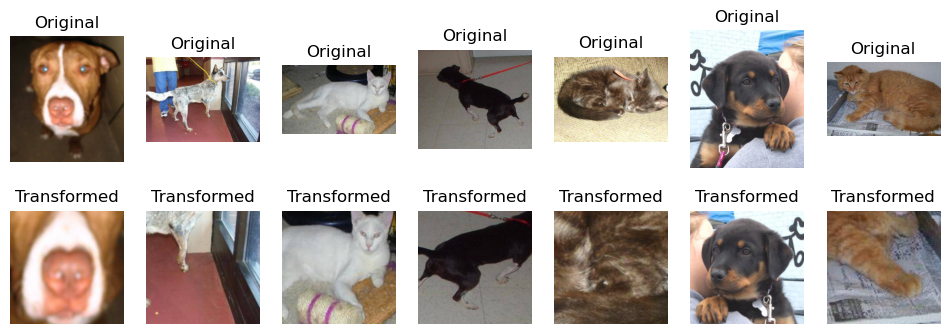

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'TEST_DIR'

In [36]:

# Function to randomly select images from a directory
def random_images_from_dir(directory, num_images):
    image_paths = []
    all_files = os.listdir(directory)
    selected_files = random.sample(all_files, num_images)
    for file in selected_files:
        if file.endswith(".jpg") or file.endswith(".png"):
            image_paths.append(os.path.join(directory, file))
    return image_paths

# Demonstrate train data transformations with random images # Replace with the path to your train directory
num_train_images = 7  # Number of random images to select from train directory
train_image_paths = random_images_from_dir(TRAIN_DIR, num_train_images)
print("Selected Train Images:", train_image_paths)
demonstrate_transforms(train_image_paths, data_transforms['train'])

# Demonstrate test data transformations with random images
test_dir = 'TEST_DIR'  # Replace with the path to your test directory
num_test_images = 3  # Number of random images to select from test directory
test_image_paths = random_images_from_dir(test_dir, num_test_images)
print("Selected Test Images:", test_image_paths)
demonstrate_transforms(test_image_paths, data_transforms['test'])
